---
# **Trabalho Final: Aplicações - INF 394 - Processamento Digital de Imagens**

## Instruções gerais

<font color="red"><strong>Comece lendo</strong></font> o arquivo `REAMDE.md`.

---

# **1. Introdução**

## **1.1. Importações de bibliotecas e ajuste de *path***

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

## **1.2. Funções utilitárias prontas**

- Aqui, temos funções já prontas, que vamos usar como suporte para adiantar um pouco de nossas tarefas

### **1.2.1. Função `mostrar_imagens`**

- A mesma que viemos usando nos Notebooks das aulas práticas

- Execute a célula a seguir.

In [4]:
#@title Função mostrar_imagens
def mostrar_imagens(imagens, legendas=None, ncolunas=None, figsize=(12, 6)):
    n = len(imagens)
    if n == 0:
        print("Nenhuma imagem fornecida.")
        return

    if legendas is None:
        legendas = [""] * n
    elif len(legendas) != n:
        raise ValueError("O número de legendas deve ser igual ao número de imagens.")

    if ncolunas is None:
        ncolunas = min(n, 4)

    nlinhas = (n + ncolunas - 1) // ncolunas  # teto

    fig, axes = plt.subplots(nlinhas, ncolunas, figsize=figsize)
    axes = np.atleast_1d(axes).ravel()

    def _prep(img):
        """Retorna (array, kwargs_imshow) adequado para monocromática ou colorida."""
        # Converte PIL -> np.array mantendo modo
        if isinstance(img, Image.Image):
            # Alguns modos úteis:
            if img.mode in ("L", "1", "I;16", "I"):
                arr = np.array(img)
                # '1' pode virar bool; tratamos abaixo em comum
            elif img.mode in ("LA",):  # L (gray) + alpha -> usa só L
                arr = np.array(img.getchannel("L"))
            elif img.mode in ("P",):   # paleta -> converte para RGB para exibição fiel
                arr = np.array(img.convert("RGB"))
            else:
                arr = np.array(img)    # RGB, RGBA etc.
        else:
            arr = np.asarray(img)

        # Se vier HxWx1, espreme o canal
        if arr.ndim == 3 and arr.shape[2] == 1:
            arr = arr[..., 0]

        # Monocromática
        if arr.ndim == 2 or arr.dtype == bool:
            if arr.dtype == bool:
                return arr, dict(cmap='gray', vmin=0, vmax=1)
            if np.issubdtype(arr.dtype, np.integer):
                vmax = np.iinfo(arr.dtype).max  # ex.: 255 (uint8), 65535 (uint16)
                return arr, dict(cmap='gray', vmin=0, vmax=int(vmax))
            else:
                # float: tenta inferir faixa típica
                amax = float(np.nanmax(arr)) if arr.size else 1.0
                vmax = 1.0 if amax <= 1.0 else (255.0 if amax <= 255.0 else amax)
                return arr, dict(cmap='gray', vmin=0.0, vmax=vmax)

        # Colorida (3/4 canais): deixa o imshow cuidar
        return arr, {}

    for ax, img, leg in zip(axes, imagens, legendas):
        arr, im_kwargs = _prep(img)
        ax.imshow(arr, **im_kwargs)
        ax.set_title(leg)
        ax.axis("off")

    # esconde eixos extras
    for ax in axes[len(imagens):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

### **1.2.2. Função `toPil`**

- A mesma que viemos usando nos Notebooks das aulas práticas

- Execute a célula a seguir.

In [5]:
#@title Função toPil
def toPil(img):
  if img.max() == 1.0:
    return Image.fromarray((img*255).round().clip(0,255).astype(np.uint8))
  else:
    return Image.fromarray(img.round().clip(0,255).astype(np.uint8))

### **1.2.3. Função `extrai_array`**

- A mesma usada na algumas das aulas práticas
- Execute a célula a seguir

In [7]:
#@title Função extrai_array
def extrai_array(img: Image, tipo: str='float') -> np.ndarray:
  if tipo == 'float':
    return np.asarray(img).astype(float)
  else:
    return np.asarray(img).astype(np.uint8)

# **2. Tarefas**

Cada tarefa, a seguir, possui um título que a identifica e estão delimitadas por uma barra horizontal, como esta que está imediatamente abaixo deste parágrafo.

---

## **Censurado**

Nesta tarefa, você deve implementar o efeito de pixelização, conforme consta no material das aulas referentes a filtragem no domínio do espaço.

Para isso, implemente uma função chamada <code>pixeliza</code>, com as seguintes especificações:

- Parâmetros:
  - `img_orig`: objeto `PIL Image` da imagem de entrada
  - `n`: tamanho do "superpixel". Ex.: se $n = 5$, o superpixel da imagem será obtido de uma matriz $5 \times 5$
  - `fcn`: função que será utilizada para agregar os dados do superpixel. Ex.: `np.mean`, `np.median`, função implementada por você etc.
- Retorno:
  - Imagem pixelizada
- Observações:
  - Sua função deve se adaptar ao número de canais da imagem. Se colorida, o resultado deve ser colorido, se monocromática, o resultado deve ser monocromático.
  - Faça a agregação por canal, no caso de uma imagem RGB.
  - Poderá acontecer, dependendo dos tamanhos da imagem e do superpixel, de um não ser múltiplo do outro, não sendo possível gerar todos superpixels do tamanho pretendido. Não há problema, se isso acontecer, simplesmente gere superpixels menores para os casos que toquem as bordas da direita e do inferior da imagem.

In [21]:
def pixeliza(img_orig, n, fcn):
    ################ COMPLETE COM SEU CÓDIGO ##################
    img = extrai_array(img_orig)
    res = np.zeros_like(img)
    h,w = img.shape[0:2]
    if len(img.shape)==2: #monocromatica
        for i in range(0, h, n):
            for j in range(0, w, n):
                blc = img[i:i+n,j:j+n]
                res[i:i+blc.shape[0], j:j+blc.shape[1]] = fcn(blc)
    else:
        c = img.shape[2]
        for i in range(0, h, n):
            for j in range(0, w, n):
                blc = img[i:i+n,j:j+n, :]
                for canal in range(c):
                    res[i:i+blc.shape[0], j:j+blc.shape[1], canal] = fcn(blc[:, :, canal])
    
    res = np.clip(res,0,255).astype(np.uint8)
    # Como sempre, ajuste o nome da variável de retorno
    return toPil(res)

Agora, implemente duas funções: `aleatorio` e `ponto_medio`, conforme especificado a seguir:

**`aleatorio`**:

- Recebe como entrada um array. Será passado, de fato, uma fatia de array para a função. Mas do ponto de vista da função, não faz diferença se trata-se de um array ou uma parcela de um array.

- Seleciona aleatoriamente e retorna um pixel deste array

**`ponto_medio`**:

- A entrada é como no caso da função `aleatorio`

- Retorna o valor do ponto médio entre o valor mínimo e o máximo do array. Lembre-se que não é meia distância entre os pontos. É o ponto médio. Por exemplo, a meia distância entre $36$ e $48$ é $\frac{48 - 36}{2} = \frac{12}{2} = 6$. Já o ponto médio entre $36$ e $48$ é $42$.

In [23]:
#pedrao, olha se vc acha q a gente pode usar essa funçao randint ou se entre no q marcao falou de nao usar funçao pronta
import random
def aleatorio(janela):
    ################ COMPLETE COM SEU CÓDIGO ##################
    h,w = janela.shape[0:2]
    i = random.randint(0, h-1)
    j = random.randint(0, w-1)

    # Ajuste o nome da variável de retorno
    return janela[i, j]

In [30]:
def ponto_medio(janela):
    ################ COMPLETE COM SEU CÓDIGO ##################
    max = janela.max()
    min = janela.min()
    # Ajuste o nome da variável de retorno
    return int((min + max)/2)

- Teste a implementação das 3 funções pedidas executando a célula a seguir.

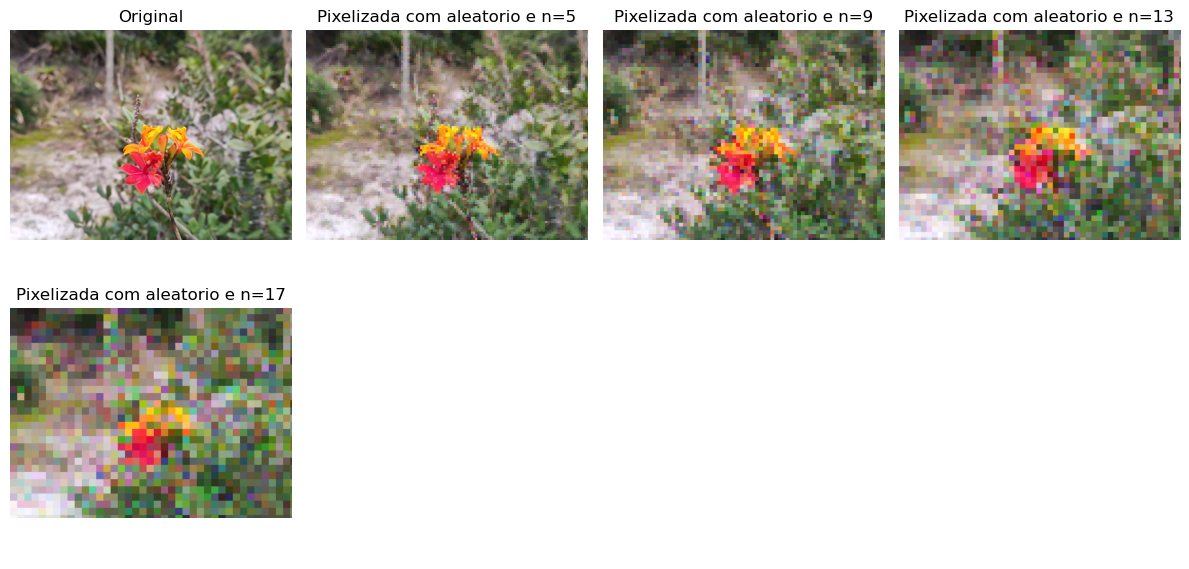

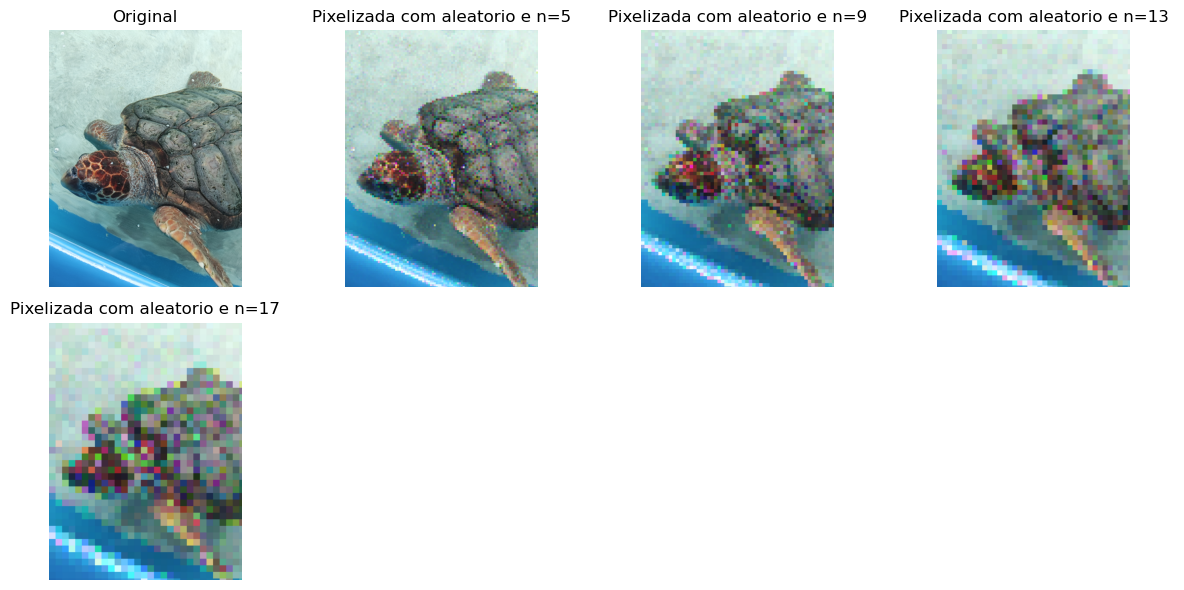

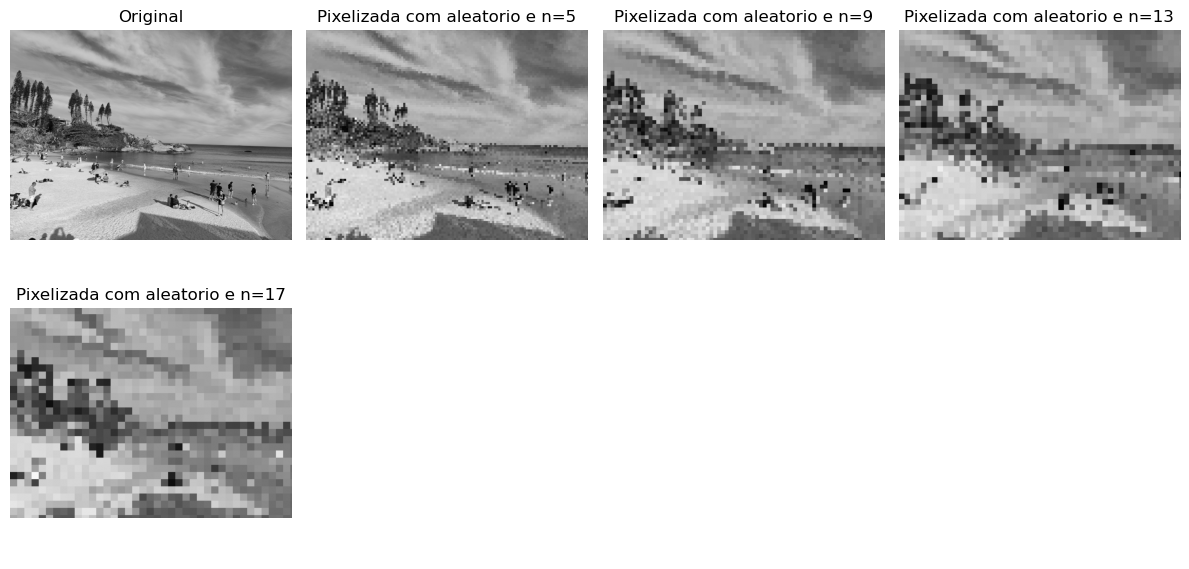

In [31]:
arquivos = ['imagens/flor_foco.png', 'imagens/tartaruga.png', 'imagens/joaquina_cinza.png']

for arquivo in arquivos:
    img = Image.open(arquivo)
    
    fcns = [np.median, ponto_medio, aleatorio]
    for fcn in fcns:
        imagens = [img]
        legendas = ['Original']
        
        for n in range(5,21,4):
            pixelizada = pixeliza(img, n, fcn)
            
            imagens.append(pixelizada)
            legendas.append(f'Pixelizada com {fcn.__name__} e n={n}')
    
    mostrar_imagens(imagens, legendas)

---

# **Viagem no tempo**

Vamos emular um efeito de envelhecimento de imagens, utilizado imagens antigas, de fato, como base.

As imagens antigas estão na subpasta `antigas`, que você copiou junto com este Notebook.

Vamos envelhecer 4 imagens:

- `santinho.png`
- `lagoa.png`
- `pavoes.png`
- `igrejinha.png`

Para fins de exemplo, será ilustrado aqui o processo para uma das imagens, usando uma outra imagem antiga como base. Há um espaço para sua implementação após as descrições e exemplos dos passos. Também há uma célula de execução de teste, como sempre.

- **Passo 1**: conversão da imagem original para monocromática. O passo inicial é converter a imagem nova para tons de cinza. Para isso, você pode usar uma implementação sua ou o método nativo das imagens PIL. Tanto faz. Para um exemplo do resultado esperado deste passo, execute a célula a seguir:

In [ ]:
img = Image.open('imagens/igrejinha.png')
imgCinza = Image.open('exemplos/igrejinha_cinza.png')
mostrar_imagens([img, imgCinza], ['Original', 'Convertida'])

- **Passo 2**: selecionar uma foto antiga e ajustar a imagem monocromática. Para que a técnica dê certo a imagem em tons de cinza não pode ter apenas um canal, ela precisa de três canais. Neste caso, basta criar uma matriz 3D com formato compatível com a imagem em tons de cinza e copiar a matriz da imagem monocromática para cada um dos canais.

Visualmente, o resultado será o mesmo, mas em termos de estrutura de dados, a matriz do objeto `imgCinzaRGB` terá 3 dimensões, cada uma delas com uma cópia da matriz contida em `imgCinza`.

Para um exemplo do resultado esperado deste passo, execute a célula a seguir:

In [ ]:
imgCinzaRGB = Image.open('exemplos/igrejinha_cinza_rgb.png')
imgAntiga = Image.open('imagens/antiga02.png')
mostrar_imagens([imgCinza, imgCinzaRGB, imgAntiga], ['Imagem monocromática', 'Imagem monocromática versão RGB', 'Imagem Antiga'])

- **Passo 3**: transferir o estilo da foto antiga para a foto nova. Este é o passo central do exercício. Para atingir este resultado, implemente uma função chamada `especificacao_direta`, que aplica a técnica de especificação direta de histograma (slides 24 a 34 do material correspondente). Especificação da função:

  - Entradas: imagem nova e imagem antiga
  - Saída: imagem nova, com estilo da antiga


 Para um exemplo do resultado esperado deste passo, execute a célula a seguir:

In [ ]:
imgEstilo = Image.open('exemplos/igrejinha_estilo_antigo.png')

mostrar_imagens([imgCinzaRGB, imgAntiga, imgEstilo], ['Imagem monocromática versão RGB', 'Imagem antiga', 'Imagem com estilo da antiga'])

- **Passo 4**: Acrescentar ruídos para simular deterioração. Note que a foto antiga de fato, apresenta alguns defeitos. Podemos tentar simular isso de forma aproximada com um ruído do tipo sal-pimenta. No entanto, ao invés de usar os tons branco e preto, que se destacariam muito na imagem, vamos usar um tom claro da paleta de cores da imagem e um tom escuro.

Neste caso, abra a imagem `antiga02.png` no seu software de edição de imagens preferido (ex.: Photoshop, GIMP etc.) e use a ferramenta de seleção de cores (comumente um ícone de conta-gotas) para selecionar um tom bem claro da foto e um bem escuro. Neste exemplo, foram selecionados os tons $(184, 150, 122)$, extraído da parte "branca" dos olhos da mulher, para representar o sal e $(65, 33, 8)$, extraído da gola do vestido da mulher, para representar a pimenta.

 Execute a célula a seguir para uma visualização destas cores:

In [ ]:
imgSal = Image.open('exemplos/cor_sal.png')
imgPimenta = Image.open('exemplos/cor_pimenta.png')

imgSalPimenta = mostrar_imagens([imgSal, imgPimenta], ['Sal', 'Pimenta'], retorno=True)


Um algoritmo em alto nível para aplicação do ruído sal-pimenta pode ser encontrado a seguir:

#### Entrada:
- `img`: A imagem sobre a qual o ruído será aplicado.
- `percentual_ruido`: Percentual de pixels que receberão o ruído, em relação ao total de pixels da imagem.
- `proporcao_sal_pimenta`: Proporção de pixels com ruído "sal" em relação aos pixels com ruído "pimenta". Por exemplo, 0.5 indica proporção igual entre sal e pimenta.
- `cor_sal`: Cor que representará o "sal". Deve ser especificada como um valor RGB em uma tupla Python. Ex.: `(230, 178, 191)`.
- `cor_pimenta`: Cor que representará a "pimenta". Deve ser especificada como um valor RGB em uma tupla Python. Ex.: `(20, 18, 11)`.

#### Saída:
- Imagem resultante com o ruído "sal-pimenta" aplicado.

#### Passos:

1. **Obtenção das Dimensões da Imagem:**
   - Obter o número total de pixels da imagem (`total_pixels`) a partir da multiplicação das dimensões da imagem.

2. **Cálculo do Número de Pixels a Serem Modificados:**
   - Calcular o número de pixels que receberão ruído (`num_pixels_ruido`) multiplicando o `total_pixels` pelo `percentual_ruido`. Arredonde o resultado.

3. **Cálculo do Número de Pixels de Sal e Pimenta:**
   - Calcular o número de pixels que receberão ruído "sal" (`num_pixels_sal`) como `proporcao_sal_pimenta * num_pixels_ruido`.
   - Calcular o número de pixels que receberão ruído "pimenta" (`num_pixels_pimenta`) como `num_pixels_ruido - num_pixels_sal`.

4. **Seleção Aleatória de Posições para o Ruído:**
   - Selecionar aleatoriamente `num_pixels_sal` posições na imagem para aplicar o ruído "sal".
   - Selecionar aleatoriamente `num_pixels_pimenta` posições na imagem para aplicar o ruído "pimenta".

5. **Aplicação do Ruído na Imagem:**
   - Para cada posição selecionada para o ruído "sal", modificar o pixel correspondente na imagem para `cor_sal`.
   - Para cada posição selecionada para o ruído "pimenta", modificar o pixel correspondente na imagem para `cor_pimenta`.

6. **Resultado:**
   - Retornar a `imagem_ruidosa` com os pixels alterados de acordo com o ruído especificado.

Para um exemplo do resultado esperado deste passo, execute a célula a seguir:

In [ ]:
imgRuido = Image.open('exemplos/igrejinha_antiga.png')
mostrar_imagens([img, imgRuido], ['Imagem Original', 'Sal-pimenta aplicado a 2% dos pixels e com 95% de sal'])

## **Viagem no tempo: 1**

- **Acrescente** quantas células de **código** precisar, a seguir

- Implemente os passos descritos no enunciado, usando as mesmas imagens (`igrejinha.png` e `antiga02.png`)

## **Viagem no tempo: 2**

- Repita o processo para as imagens `pavoes.png` e `antiga01.png`. Neste caso, sem o passo final, da adição de ruído.

Execute a célula a seguir para ver o resultado esperado:

In [ ]:
img = Image.open('imagens/pavoes.png')
imgAntiga = Image.open('imagens/antiga01.png')
imgEstilo = Image.open('exemplos/pavoes_antigo.png')

mostrar_imagens([img, imgAntiga, imgEstilo], ['Imagem Original', 'Imagem antiga', 'Imagem com estilo da antiga'])

- **Acrescente** quantas células de **código** precisar, a seguir

## **Viagem no tempo: 3**

- Repita o processo do exercício anterior para as imagens `lagoa.png` e `antiga03.png`. Neste caso, também não haverá o passo final, da adição de ruído

Execute a célula a seguir para ver o resultado esperado:

In [ ]:
img = Image.open('imagens/lagoa.png')
imgAntiga = Image.open('imagens/antiga03.png')
imgEstilo = Image.open('exemplos/lagoa_antiga.png')

mostrar_imagens([img, imgAntiga, imgEstilo], ['Imagem Original', 'Imagem Antiga', 'Imagem com estilo da antiga'])

- **Acrescente** quantas células de **código** precisar, a seguir

## **Viagem no tempo: 4**

- Para a primeira parte, repita o processo do exercício anterior para as imagens `santinho.png` e `antiga04.png`.

Execute a célula a seguir para ver o resultado esperado:

In [ ]:
img = Image.open('imagens/santinho.png')
imgAntiga = Image.open('imagens/antiga04.png')

imgEstilo = Image.open('exemplos/santinho_estilo.png')

mostrar_imagens([img, imgAntiga, imgEstilo], ['Imagem Original', 'Imagem Antiga', 'Imagem com estilo da antiga'])


- Repare que a foto antiga parece um pouco "texturizada" com um efeito meio pontilhado

- Podemos emular isto acrescentando um ruído gaussiano à imagem

- Um algoritmo para acrescentar ruído gaussiano à imagem é dado a seguir:

#### Entradas

- `img`: imagem RGB
- `alfa`: fator de atenuação de ruído. Valor *default*: $0.04$

#### Saída

- Imagem com ruído adicionado

#### Passos

- Sendo: `a` a matriz de `img`, com dimensões `n` (linhas), `m` (colunas) e $3$ (canais)

- Gere uma matriz `r`, de fatores de ruídos gaussianos no formato `n` por `m` (sem os canais). Para isso, pode-se utilizar a função `np.random.normal` e especificar o parâmetro `size` para as dimensões desejadas (`n` $\times$ `m`)

- O fator de ruído gaussiano será um multiplicador para os valores dos pixels em `a`, e a matriz `r` conterá valores compreendidos no intervalo $[0,1]$. Isso pode gerar ruídos muito intensos. Por isso utilizaremos um fator de atenuação, para que os ruídos sejam minimizados. Para tal, multiplique `r` por `alfa`, para gerar uma matriz `r` atenuada

- Com isso, os fatores de ruído agora estarão compreendidos no novo intervalo $[0, 0.04]$. Aplicaremos este ruído a cada canal de `a`. Assim, **para cada canal `c`, de `a`, faça:**

  - Gere os ruídos de fato, multiplicando `r` pelo canal `c`, de `a`

  - Some os ruídos gerados aos valores do canal `c`, atualizando `a`

- Gere a imagem a partir de `a` e retorne a mesma

Execute a célula a seguir para visualizar o resultado esperado

In [ ]:
imgFinal = Image.open('exemplos/santinho_antiga.png')

mostrar_imagens([img, imgAntiga, imgFinal], ['Imagem Original', 'Imagem Antiga', 'Imagem final'])

- **Acrescente** quantas células de **código** precisar, a seguir

---

# **Reconstruindo imagens**

Um hacker malicioso, porém amador, decidiu codificar uma série de imagens do banco de imagens de uma empresa que invadiu. A ideia do hacker era pedir um valor de "resgate" e, após pago, ele decodificaria as imagens de volta aos seus formatos originais.

A empresa então te contratou para analisar a situação e, se possível, desenvolver um algoritmo que permitisse fazer a decodificação.

Felizmente, o hacker era amador e seus conhecimentos eram bastante limitados e você rapidamente descobriu como reverter o processo.

O hacker substituiu os arquivos das imagens por outros, com a extensão `.hir`, onde foram salvos os dados codificados. Ao tentar abrir o arquivo, você descobriu que o mesmo estava em formato textual e possuía a seguinte estrutura:

- Na primeira linha do arquivo, estão 3 valores inteiros, separados por espaços. Após alguns testes, você deduziu que estes valores correspondem, respectivamente, à quantidade de linhas, quantidade de colunas e quantidade de canais da imagem. Nesta ordem

- Nas demais linhas, encontram-se strings contendo informação em um padrão amplamente conhecido e bastante difundido no meio do Desenvolvimento Web: a notação hexadecimal.

- Como esta notação é utilizada para representar cores RGB em um modelo mais compacto, foi natural deduzir que cada linha do arquivo (exceto a primeira) correspondia à informação de um pixel, que seria lido sequencialmente e alocado na matriz da imagem, de acordo com o número de linhas e colunas informados na primeira linha do arquivo.

- Um último detalhe que você notou foi que quando a quantidade de canais era 3, o valor do pixel era como em `#FF038D`, e quando a quantidade era 1, o valor do pixel era como em `#A8`.

Cabe a você implementar o código da função `decodifica`, abaixo, que reconstroi uma imagem a partir de um arquivo `.hir`.

A função recebe, como entrada, o nome do arquivo `.hir` e retorna um objeto `PIL Image` como resposta.

Para auxiliar na tarefa, já existe uma função pronta chamada `arq2list`, que recebe o nome do arquivo de entrada e retorna o seu conteúdo em uma lista, onde cada item corresponde a uma linha de texto do arquivo.

<p>&nbsp;</p>

**A notação hexadecimal**

A representação hexadecimal utilizada nos arquivos `.hir` para denotar uma cor em formato RGB consiste em uma string de 7 caracteres, onde o primeiro caractere é uma *hashtag* (#) e os demais representam os valores de intensidade para cada canal.

Assim sendo, o primeiro par de caracteres representa um número hexadecimal para o canal vermelho, o segundo par representa um número hexadecimal para o canal verde e os dois últimos representa um número hexadecimal para o canal azul. Por exemplo:

- A string `#FF038D` representa a cor `(255, 3, 141)`, uma vez que $\mathrm{FF}_{hex} = 255_{dec}$, $\mathrm{03}_{hex} = 3_{dec}$ e $\mathrm{8D}_{hex} = 141_{dec}$

Já para uma imagem monocromática, a representação hexadecimal utilizada foi uma *hashtag* seguida de um par de caracteres representando o valor hexadecimal para uma dada intensidade de cinza. Por exemplo:

- A string `#A8` representa o tom 168, pois $\mathrm{A8}_{hex} = 168_{dec}$

In [ ]:
# Função auxiliar pronta
def arq2list(arq):
  fp = open(arq, 'r')
  linhas = []
  while True:
    linha = fp.readline().strip()
    if not linha:
      break
    linhas.append(linha)
  fp.close()

  return linhas

def decodifica(arq):
  ################ COMPLETE COM SEU CÓDIGO ##################

  # Ajuste o nome da variável de retorno
  return I

#### **Testando seu código**

Execute a célula abaixo para testar sua solução. As imagens `.hir` estão na pasta `hir`.

In [ ]:
pth = 'hir/'
imgs = []
legs = []
for arq in os.listdir(pth):
  if os.path.isfile(pth + arq) and arq.endswith('.hir'):
    img = decodifica(pth + arq)
    imgs.append(img)
    legs.append('Visualização do conteúdo de %s' % arq)

mostrar_imagens(imgs, legs)

---

# **Minha cabeça está rodando...**

Este exercício não tem nenhum enunciado elaborado ou com *story telling*. Vamos direto ao ponto...

Implemente a função `rotaciona`, que como o nome sugere, implementa a rotação de uma imagem por um ângulo qualquer.

Parâmetros:

- `img`: imagem de entrada

- `angulo`: ângulo de rotação, em graus. Lembre-se de que o ângulo deve ser convertido para radianos, internamente à função, para que os cálculos mostrados em aula funcionem.

Retorno:

- Imagem rotacionada, com o mesmo formato da original

Observações:

- Implemente a abordagem "destino pega da fonte"

- Devido à saída possuir o mesmo formato da imagem de entrada, não expanda a imagem resultante. Os pixels que porventura forem destinados a posições fora dos limites da imagem devem ser simplemente ignorados/descartados

- Os pixels da imagem resultante que não receberem nenhum pixel orginal deverão ter a cor preta

In [ ]:
def rotaciona(img, angulo):
  #################### COMPLETE COM SEU CÓDIGO #############
  return img

- Execute o código a seguir para testar sua implementação

- **Atenção:** dependendo da sua implementação, a execução pode ser demorada.

In [ ]:
img = Image.open('imagens/reflexo_sol.png')
w, h = img.size
img = img.resize((w//2, h//2))

angulos = [13, 45, 90, 180, 238]
imgs = [img]
legs = ['Original']

for angulo in angulos:
  imgRot = rotaciona(img, angulo)
  imgs.append(imgRot)
  legs.append('Rotação em %d graus' % angulo)

mostrar_imagens(imgs, legs)

---

# **Foi pego no radar**

Na pasta `radar` existem uma série de arquivo com extensão `.npy`. Neles, estão salvas matrizes de **dados reais** obtidos por satélite via radar. Ao carregar o conteúdo do arquivo para um array, obtemos a estrutura de dados com formato conforme a seguir. (Execute a célula para visualizar)

In [ ]:
arr = np.load('radar/R_00.npy')

print(f'Formato do array: {arr.shape}')
print(f'Tipo de dados contidos: {arr.dtype}')

Conforme pode ser visto, trata-se de um array com 4 dimensões, com dados em ponto flutuante de 16 bits. As dimensões são:

- Série temporal com 65 leituras de radar, em datas distintas, sobre uma mesma região

- Linhas da matriz de cada leitura

- Colunas da matriz de cada leitura

- Bandas (canais) de leitura do radar (não são RGB)

<p>&nbsp;</p>

Se tomarmos uma leitura qualquer, digamos a da posição 20 da série temporal, podemos averiguar, também, o domínio dos dados de cada banda: (execute a célula a seguir)

In [ ]:
leitura = arr[20]

for b in range(leitura.shape[2]):
  print(f'Banda {b}: valores de {leitura[:,:,b].min()} a {leitura[:,:,b].max()}')

Como já mencionado, estes dados não consistem em valores RGB, são leituras de radar, com suas medidas e domínios próprios. No entanto, podemos gerar uma visualização a partir destes dados, como se fossem uma imagem RGB.

<p>&nbsp;</p>

Assim, podemos normalizar os valores no intervalo $[0,1]$, com o mínimo de cada banda sendo mapeado para $0$ e o máximo para $1$. Os demais valores ficam distribuídos proporcionalmente neste intervalo, respeitando as proporções do domínio de valores original. Depois, projetamos esses valores no domínio dos valores RGB ($[0, 255]$).

<p>&nbsp;</p>

Temos um exemplo de como fazer isso no material da disciplina, na parte sobre alargamento de contraste (material de histogramas). Mas, recapitulando, podemos fazer isso da seguinte maneira:

<p>&nbsp;</p>

$$
V_{\text{rgb}} = \frac{V_{\text{orig}} - \text{min}(V_{\text{orig}})}{\text{max}(V_{\text{orig}}) - \text{min}(V_{\text{orig}})} \cdot 255
$$

onde:

- $V_{\text{orig}}$ é o valor de um dado qualquer na matriz do domínio original do canal

- $\text{max}(V_{\text{orig}})$ é o valor máximo do canal

- $\text{min}(V_{\text{orig}})$ é o valor mínimo do canal

- $V_{\text{rgb}}$ é o valor de um dado qualquer do canal após normalização e ajuste para o domínimo do modelo RGB

<p>&nbsp;</p>

A partir deste ajuste, podemos gerar uma visualização. Execute a célula a seguir para ver a visualização da mesma leitura da posição 20, testada anteriormente.

In [ ]:
leitura_rgb = np.zeros_like(leitura)

for b in range(leitura.shape[2]):
  mn = leitura[:,:,b].min()
  mx = leitura[:,:,b].max()
  leitura_rgb[:,:,b] = (leitura[:,:,b] - mn) / (mx - mn) * 255

img = toPil(leitura_rgb)

display(img)

No entanto, temos um problema para resolver. Os dados de radar são muito ruidosos, vejamos exemplos de visualização de algumas posições de leitura arbitrárias: (execute a célula a seguir)

In [ ]:
posicoes = [0, 10, 20, 30, 40, 50]
imgs = []
legendas = []

for pos in posicoes:
  leitura = arr[pos]
  leitura_rgb = np.zeros_like(leitura)

  for b in range(leitura.shape[2]):
    mn = leitura[:,:,b].min()
    mx = leitura[:,:,b].max()
    leitura_rgb[:,:,b] = (leitura[:,:,b] - mn) / (mx - mn) * 255

  img = toPil(leitura_rgb)
  imgs.append(img)
  legendas.append(f'Posição {pos}')

mostrar_imagens(imgs, legendas)

É fácil perceber que há uma variação considerável entre as leituras.

<p>&nbsp;</p>

Sua tarefa é, a partir dos dados disponíveis gerar uma leitura "limpa", como da célula a seguir (execute para ver o exemplo de cada uma das 5 regiões monitoradas).

<p>&nbsp;</p>

Na primeira linha, temos as leituras "limpas" do radar e na segunda, temos fotos (RGB, obtidas da luz visível) das mesmas regiões, para fins de comparação.

In [ ]:
mosaico_radar = Image.open('exemplos/radar_limpo.png')
display(mosaico_radar)
mosaico_rgb = Image.open('exemplos/radar_rgb.png')
display(mosaico_rgb)

In [ ]:
imgs = []
for ix in range(5):
  arr = np.load(f'radar/R_{ix:02d}.npy')
  print(f'Lido arquivo R_{ix:02d}.npy, com formato: {arr.shape}')
  ############################# COMPLETE COM SEU CÓDIGO ############################
  ##############################################################
legendas = ['Região 1', 'Região 2', 'Região 3', 'Região 4', 'Região 5']
mostrar_imagens(imgs, legendas)

---

# **Vamos economizar tinta**

Uma gráfica entrou em contato com você pedindo que a ajudasse a produzir material didático e cultural a custos menores, para que ficassem mais acessíveis. Uma das estratégias adotadas, e onde você entra nessa história, foi quantizar as imagens ilustrativas presentes nos materiais, diminuindo, assim as paletas de cores das imagens.

Conforme visto em sala, a quantização consiste em fazer uma discretização dos tons que vamos utilizar para representar as possíveis cores presentes em uma imagem. Em outras palavras, isto equivale a determinar uma paleta de cores para uma dada imagem.

Dois caminhos possíveis para se fazer uma quantização, de forma que se reduza a paleta de cores de uma certa imagem, são reduzir a quantidades absoluta de cores a serem utilizadas ou reduzir a quantidade de níveis de intensidade em cada canal.

Por exemplo: a partir de uma imagem RGB (~$16$ milhões de cores = $256 \times 256 \times 256$), queremos fazer uma redução de paleta de cores.

Podemos estabelecer, em uma primeira abordagem, a quantidade de níveis por canal para $8$, de onde teremos $8 \times 8 \times 8 = 512$ cores possíveis na nova paleta.

Em uma segunda abordagem podemos obter uma paleta de cores com um total de matizes pré estabelecida com, digamos, $64$ cores, isto é, queremos que a paleta resultante tenha $64$ possibilidades de cor.

Como proposta de solução à gráfica, você irá oferecer soluções que usam as duas abordagens.

### **Abordagem 1: Quantização de níveis de intensidade**

Nesta primeira abordagem, vamos reduzir a quantidade de níveis por canal. A ideia é bastante simples:

1. Estabelece-se uma nova quantidade $qtd$ de níveis

1. Determina-se um fator de ajuste como sendo $f = \frac{255}{qtd - 1}$

1. Para cada nível presente em cada canal da imagem, calcula-se o novo nível como sendo: $novo = arred(\frac{nível}{f + 0,5}) \cdot f$, onde $arred$ é uma função de arredondamento de valores.

Na célula a seguir, complete o código da função `quantizaNiveis` para que implemente o método descrito acima. A função deve ter:

- Parâmetros:

  - `img`: imagem RGB ou monocromática de entrada

  - `qtd`: nova quantidade de níveis por canal

- Retorno:

  - Objeto `PIL Image`, com as cores quantizadas

In [ ]:
def quantizaNiveis(img, qtd):
  ################################ COMPLETE COM SEU CÓDIGO ##################


#### **Teste sua solução**

Execute a célula abaixo, para testar sua implementação.

In [ ]:
img = Image.open('imagens/jardim.png')

niveis = [16, 8, 4]
imgs = [img]
legs = ['Original: 256 níveis (~16mi de cores)']

for nivel in niveis:
  imgQuant = quantizaNiveis(img, nivel)
  imgs.append(imgQuant)
  possib = nivel**3
  legs.append('Quantizada com %d níveis (%d cores possíveis)' % (nivel, possib))

mostrar_imagens(imgs, legs, colunas=2)

### **Abordagem 2: Quantização por quantidade de cores**

Embora seja mais intuitiva de se pensar, a implementação por quantidade de cores não é tão direta quanto a abordagem anterior e existem muitos diferentes métodos para fazê-la.

Veremos, neste exercício, um deles, que se chama *median cut*, cuja ideia central é subdividir a imagem em regiões sucessivamente, usando a mediana do canal com maior variação de valores como ponto de corte.

Assim, partimos de uma imagem completa, mapeamos seus pixels em duas regiões, depois cada região é particionada em duas regiões novamente e assim por diante, até encontrarmos uma quantidade de regiões igual ao número de cores para a qual desejamos quantizar a imagem.

Na implementação, temos de ter cautela para evitar produzir regiões vazias, não subdividindo regiões com poucos pixels presentes. Além disso, é conveniente utilizar um "mapa", uma estrutura de dados indicando qual o id da região que cada pixel pertence.

Algoritmo do *median-cut* apresenta um elemento recursivo e encontra-se descrito por meio das 3 funções a seguir:

<p>&nbsp;</p>

**Função** `divide_regiao(id, id', q)`:

**Sejam:**
- $R$ a região da imagem identificada por $id$
- $id'$ o id da nova região a ser criada a partir de $R$
- $q$ a quantidade mínima de pixels por região

**Passos:**

**Se** $\mathrm{tamanho}(R) \geq q$ **então**:

  1. Identifica o canal $c$, que apresenta a maior variação de valores naquela região da imagem

  1. Calcula a mediana $m$, dos valores de $c$

  1. $R' \leftarrow \{p \in R | \mathrm{valor}(p) > m\}$

  1. **Se** $R' = \emptyset$:
      - **retorna** *Falso*

  1. **Para** $p \in R$, onde $\mathrm{valor}(p) > m$:
    
    - $\mathrm{valor}(p) \leftarrow id'$

  - **retorna** *Verdadeiro*

**Senão**:
  - **retorna** *Falso*

<p>&nbsp;</p>

**Função** `percurso(o, n, t, q)`:

**Sejam:**
- $o$ a lista de percurso em largura
- $n$ o nível de profundidade de subdivisão das regiões
- $t$ a quantidade de tons (cores) que se desejam atingir
- $q$ a quantidade mínima de pixels por região

**Passos:**

1. $n \leftarrow n + 1$

1. **Se** $\mathrm{tamanho}(o[n-1]) \leq t$ **então**
  1. Adiciona lista vazia ao final de $o$

  1. **Para cada** $v \in o[n-1]$ **faça**

    1. Adiciona $v$ ao final de $o[n]$

    1. **Se** $\mathrm{tamanho}(o[n]) = t$ **então encerra laço**

    1. $w \leftarrow v + 2^{n-1}$

    1. **Se** `divide_regiao(v, w, q)` **então**

        1. Adiciona $w$ ao final de $o[n]$

        1. **Se** $\mathrm{tamanho}(o[n]) = t$ **então encerra laço**

  1. **Se** $\mathrm{tamanho}(o[n]) < t$ **então**

    1. `percurso(o, n, t, q)`

<p>&nbsp;</p>

**Função** `median_cut(im, t, q, f)`:

**Sejam:**
- $im$ a imagem de entrada
- $t$ a quantidade de tons (cores) que se desejam atingir
- $q$ a quantidade mínima de pixels por região
- $f$ a função que agrega cores de uma mesma região

**Passos:**

1. $o \leftarrow \mathrm{lista}(\mathrm{lista}(0))$

1. $n \leftarrow 0$

1. `percurso(o, n, t, q)`

1. $u \leftarrow $ *sublista da última posição de* $o$

1. **Para cada** $i \in u$ **faça**

  1. $R \leftarrow $ *pixels da imagem com* $id = i$

  1. $C \leftarrow f(R)$

  1. $\forall p \in R, p \leftarrow C$

- **retorna** *imagem produzida a partir de* $R$

<p>&nbsp;</p>

Na célula abaixo, implemente a quantização por *median cut*. A assinatura da função `median_cut` já se encontra pronta, a fim de manter a compatibilidade com o código que testará sua implementação. No entanto, você pode adicionar código de novas funções auxiliares para serem usadas por `median_cut`, se assim desejar (dica: o uso de funções auxiliares facilitará a solução). Ou seja, você tem toda liberade para implementar da forma que quiser, desde que sua solução seja evocável por meio da função `median_cut`, que tem as seguintes especificações:

- Parâmetros:

  - `img`: imagem RGB ou monocromática de entrada

  - `n_tons`: quantidade de tons (cores) desejadas

  - `funcao`: função que irá produzir a cor representante do grupo. Tem de dar suporte ao parâmetro `axis`, como `np.mean`, `np.median` etc.

- Retorno:

  - Objeto `PIL Image`, com a imagem com as cores quantizadas

***Obs.:** para fins de simplifcar a solução, só vamos aceitar aplicar o algoritmo *median cut* quanto a quantidade de tons desejados for uma potência de 2 (4, 8, 64 etc.). Isto já está assegurado como primeira linha do código da função `median_cut`, com a cláusula `assert`.

In [ ]:
################################ INÍCIO DO SEU CÓDIGO ##################
## Adicione as funções auxiliares aqui
################################ TÉRMINO DO SEU CÓDIGO ##################

def median_cut(img, n_tons, funcao=np.median):
  # Assegura que n_tons é uma potência de dois
  assert potencia2(n_tons)

  ################################ COMPLETE COM SEU CÓDIGO ##################

#### **Teste sua solução**

Execute a célula abaixo para testar sua implementação.

In [ ]:
img = Image.open('imagens/jardim.png')
funcoes = [np.median, np.mean, np.max, np.min]
nomes = ['Mediana', 'Média', 'Máximo', 'Mínimo']

for i,funcao in enumerate(funcoes):
  imgs = [img]
  legs = ['Original']
  ncores = 256
  while ncores > 1:
    imgQ = median_cut(img, ncores, funcao)
    imgs.append(imgQ)
    legs.append('%d cores (%s)' % (ncores, nomes[i]))

    ncores //= 2

  mostrar_imagens(imgs, legs, colunas=3)

### **Comparando os métodos**

Como resultado final de seu projeto, você irá preparar um relatório para a gráfica comparando os métodos que você desenvolveu.

Na célula a seguir encontra-se um pequeno código que produz resultados que potencialmente geram 64 cores, utilizando cada um dos métodos de quantização implementados.

O exemplo utiliza $4$ níveis de intensidade para o método da abordagem 1, pois quatro níveis de intensidade em cada canal nos leva a $4^{3} = 64$ cores possíveis. Já para o método da abordagem 2, informamos o parâmetro de quantidade de cores como sendo $64$ diretamente e estamos utilizando a função *default*, isto é, a mediana.

Execute a célula a seguir e responda as questões subsequentes.

In [ ]:
imgQ_basica = quantizaNiveis(img, 4)
imgQ_mc = median_cut(img, 64)

imgs = [img, imgQ_basica, imgQ_mc]
legs = ['Original', 'Quantizada para 4 níveis (64 cores possíveis)', 'Quantizada para 64 cores com median-cut']
mostrar_imagens(imgs, legs, colunas=3)

a) Os dois resultados são claramente diferentes. Por que você acha que isso aconteceu? (escreva a resposta na célula a seguir)

b) Como você poderia fazer um código para verificar se sua hipótese da resposta anterior está ou não correta? Não é necessário fazer o código, apenas explicar o que seria feito. (use a célula a seguir para responder)

---

# **Agora é a vez das crianças**

A mesma gráfica do exercício anterior, gostou do seu trabalho e decidiu te contratar para mais um projeto. Este, agora, relacionado à produção de um material dedicado ao público infantil. E crianças gostam de cores bem vivas.

A empresa já dispõe de uma série de ilustrações, porém o diretor artístico julgou que estas não estão com cores chamativas o suficiente para cativar o público alvo.

Você deciciu explorar o uso de diferentes técnicas para deixar as cores de uma imagem mais vivas, mexendo em dois aspectos: contraste e saturação das cores.

É possível fazer ambas operações usando o modelo RGB, no entanto, é consideravelmente mais fácil de implementar se convertermos a imagem para o modelo HSL antes, pois, neste modelo, o canal S já é um parâmetro de saturação e devemos, então, apenas manipular o valor deste canal em questão. Além disso, o canal L já é um parâmetro de luminosidade, então basta aprimorar este aspecto operando somente neste canal. Depois de feitas as operações, é só converter a imagem novamente para o modelo RGB e visualizar o resultado.

Assim, os passos gerais são:

1. <u>Converter a imagem para HSL</u>. Já fizemos este exercício em uma aula prática. Portanto, não será cobrado aqui e você pode apenas trazer a solução implementada lá ou então utilizar alguma conversão já pronta em uma biblioteca como OpenCV, PIL, skimage etc.

1. <u>Alargar o contraste do canal L</u>. Neste passo, visamos aprimorar o contraste da imagem. Então, opere sobre o canal L obtido no passo anterior a fim de alargar seu contraste, conforme dado em sala de aula. Esteja atento(a) aos valores limites do canal, pois dependendo de onde você aproveitou a implementação da conversão, os valores podem estar em domínios diferentes.

1. <u>Alterar a saturação da imagem, operando no canal S</u>. Vamos detalhar este passo mais adiante.

1. <u>Converter o resultado para RGB</u>. Após promover as alterações dos dois passos anteriores, converta a imagem novamente para RGB. Novamente, você está livre para utilizar uma solução pronta.

Sobre a saturação:

Uma função comumente utilizada neste tipo de operação é calcular o novo valor $S'$, saturado, como sendo: $S' \leftarrow S + f \cdot (1 - S) \cdot S$, onde:

  - $S$ é o canal S do modelo HSL
  - $f$ é um fator de saturação que, para efeitos de produzir melhores visualizações vamos limitar em $-2 \leq f \leq 2$
  - $S'$ é o novo valor obtido

Esta função que calcula $S'$ produz o seguinte tipo de efeito no canal $S$ original:

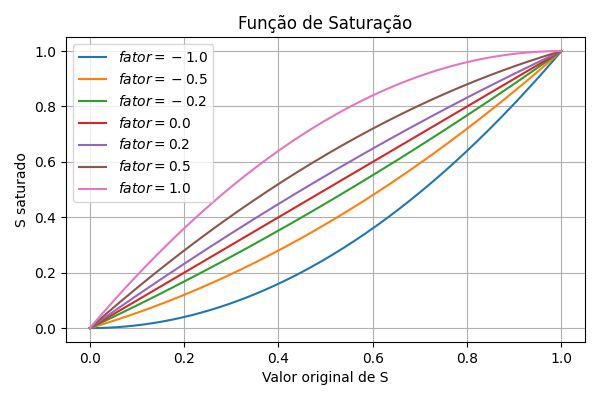

Na célula a seguir, complete o código da função `aprimora` para que implemente os passos aqui descritos.

- Parâmetros:

  - `img`: imagem RGB original (não deve aceitar imagem monocromática)

  - `f`: fator $f$, da fórmula acima

- Retorno:

  - Objeto `PIL Image`, em formato RGB

In [ ]:
################################ INÍCIO DO SEU CÓDIGO ##################
# Adicione funções auxiliares aqui, se desejar
################################ TÉRMINO DO SEU CÓDIGO ##################

def aprimora(img, f, alarg=True):
  assert img.mode == 'RGB'
  assert -2 <= f <= 2

  ################################ COMPLETE COM SEU CÓDIGO ##################

#### **Testando sua solução**

Execute a célula a seguir para testar sua implementação.

In [ ]:
img = Image.open('imagens/igrejinha.png')
imgs = [img]
legs = ['Original']

fatores = np.arange(-2, 2.5, 0.5)

for f in fatores:
  imgAp = aprimora(img, f)
  imgs.append(imgAp)
  legs.append('f = %.1f' % f)

mostrar_imagens(imgs, legs, colunas=3)

---

# **Tranferência estatística de estilos**

Em sala de aula, vimos a transferência de estilos entre uma imagem e outra, usando a técnica conhecida como **Especificação Direta de Histograma**. Uma técnica alternativa de se transferir estilos entre imagens consiste em usar o desvio padrão e a média das cores das imagens de alvo e estilo para que se faça com que o histograma da imagem alvo "se pareça" com o da imagem de estilo. Para que o resultado fique visualmente bom, é interessante que usemos um espaço de cores que leva em conta a percepção humana, como o modelo conhecido como CIE-Lab (ou CIELAB). Sendo assim, vamos trabalhar com imagens convertidas para este modelo de cores.

Desta vez, não vamos implementar a conversão de imagens RGB x CIELAB, pois esta implementação tem nuances e parâmetros de calibração que a tornam um tanto delicada de se trabalhar. Ao invés disso, vamos usar uma implementação presente no submódulo `skimage.color`, que foi importado na primeira célula de código deste Notebook. Para converter de RGB para CIELAB, basta fazer a chamada da função `color.rgb2lab`, informando um array ou uma imagem `PIL Image` como parâmetro. Para a transformação no sentido inverso, a função se chama `color.lab2rgb`.

O modelo CIELAB tem como característica trabalhar com 3 canais diferentes. O primeiro deles, o canal L, traz informação exclusivamente de luminância da imagem, com valores $L \in [0,100]$. O segundo canal, a, traz informação de cor em um eixo que vai do verde (valores negativos) ao vermelho (valores positivos). Na implementação do módulo `skimage`, $a \in [-86.183, 98.233]$. O terceiro canal, b, traz informação de cor em um eixo que vai do azul (valores negativos) ao amarelo (valores positivos). Na implementação do módulo `skimage`, $b \in [-107.857,94.478]$.

Estes valores "quebrados" se devem aos detalhes de implementação mencionados, mas cobrem as cores perceptíveis para o ser humano. Outro detalhe importante é que, se duranto o uso de uma das funções, um *warning* do tipo: `UserWarning: Color data out of range` surgir, não se preocupe. É apenas um aviso de que algumas cores sofrerão uma "poda" para os intervalos ilustrados acima. Você pode ignorar estes avisos.

O espaço CIELAB tem como principal característica organizar as cores de acordo com a maneira que os seres humanos percebem as similaridades entre as mesmas, portanto é muito utilizado em várias aplicações onde medir a semelhança entre cores é importante.

Implemente uma função chamada `especificacao_direta`, que transfere estilo de uma imagem para a outra, conforme especificado nos materiais de aula.

Especificações da função:

- Parâmetros:
  - `arr_alvo`: array de dados da imagem que cederá as formas dos objetos da imagem resultante, em modo **RGB**
  - `arr_estilo`: array de dados da imagem que cederá o estilo de cores da imagem resultante, em modo **RGB**
  
- Retorno:
  - Array da imagem resultante

- Observações:
  - Sua função **deve** lançar uma exceção caso os arrays de entrada sejam de imagens monocromáticas

Implemente, ainda, uma função chamada `fast_transfer`, que emprega a técnica descrita a seguir.

- Converta ambos arrays de entrada para o tipo `np.uint8`
- Converta `imgAlvo` para CIELAB, gerando $a$
- Converta `imgEstilo` para CIELAB, gerando $e$
- Em cada canal $c$, de $a$, faça:
    - $a_{c} \leftarrow (\sigma_{c}^{e}/\sigma_{c}^{a}) \cdot (a_{c} - \mu_{c}^{a}) + \mu_{c}^{e}$
    - onde:
        - $\mu_{c}^{a}$ é a média dos valores do canal $c$ em $a$
        - $\mu_{c}^{e}$ é a média dos valores do canal $c$ em $e$
        - $\sigma_{c}^{a}$ é o desvio padrão dos valores do canal $c$ em $a$
        - $\sigma_{c}^{e}$ é o desvio padrão dos valores do canal $c$ em $e$
- Converta $a$ para RGB, gerando $saida$
- Ajuste a escala da imagem resultante: $saida \leftarrow saida \cdot L_{max}$
- Retorne $saida$

Especificações da função:

- Parâmetros:
  - `arr_alvo`: array de dados da imagem que cederá as formas dos objetos da imagem resultante, em modo **RGB**
  - `arr_estilo`: array de dados da imagem que cederá o estilo de cores da imagem resultante, em modo **RGB**
  - `Lmax`: valor inteiro, representando o nível máximo de intensidade que o(s) canal(is) pode(m) ter. Opcional. Valor *default*: 255

- Retorno:
  - Array da imagem resultante

- Observações:
  - Sua função **deve** lançar uma exceção caso os arrays de entrada sejam de imagens monocromáticas

#### Complete os códigos das funções abaixo

In [ ]:
def especificacao_direta(arr_alvo, arr_estilo):
  ####### COMPLETAR #######

In [ ]:
def fast_transfer(arr_alvo, arr_estilo, Lmax=255):
  ####### COMPLETAR #######

#### Execute as $8$ células abaixo para testar seu código.

In [ ]:
img_alvo = Image.open('imagens/capivara.jpg')
arr_alvo = np.asarray(img_alvo, dtype=float)

img_estilo = Image.open('imagens/grilo.jpg')
arr_estilo = np.asarray(img_estilo, dtype=float)

arr_espec = especificacao(arr_alvo, arr_estilo)
img_espec = toPil(arr_espec)

arr_fast = fast_transfer(arr_alvo, arr_estilo)
img_fast = toPil(arr_fast)

imgs = [img_alvo, img_estilo, img_espec, img_fast]
legs = ['Imagem Alvo', 'Imagem do Estilo', 'Especificação Direta', 'Transferência Estatística']
mostrar_imagens(imgs, legs, colunas=4)

In [ ]:
img_alvo = Image.open('imagens/grilo.jpg')
arr_alvo = np.asarray(img_alvo, dtype=float)

img_estilo = Image.open('imagens/capivara.jpg')
arr_estilo = np.asarray(img_estilo, dtype=float)

arr_espec = especificacao(arr_alvo, arr_estilo)
img_espec = toPil(arr_espec)

arr_fast = fast_transfer(arr_alvo, arr_estilo)
img_fast = toPil(arr_fast)

imgs = [img_alvo, img_estilo, img_espec, img_fast]
legs = ['Imagem Alvo', 'Imagem do Estilo', 'Especificação Direta', 'Transferência Estatística']
mostrar_imagens(imgs, legs, colunas=4)

In [ ]:
img_alvo = Image.open('imagens/hindu.jpg')
arr_alvo = np.asarray(img_alvo, dtype=float)

img_estilo = Image.open('imagens/favela.jpg')
arr_estilo = np.asarray(img_estilo, dtype=float)

arr_espec = especificacao(arr_alvo, arr_estilo)
img_espec = toPil(arr_espec)

arr_fast = fast_transfer(arr_alvo, arr_estilo)
img_fast = toPil(arr_fast)

imgs = [img_alvo, img_estilo, img_espec, img_fast]
legs = ['Imagem Alvo', 'Imagem do Estilo', 'Especificação Direta', 'Transferência Estatística']
mostrar_imagens(imgs, legs, colunas=4)

In [ ]:
img_alvo = Image.open('imagens/favela.jpg')
arr_alvo = np.asarray(img_alvo, dtype=float)

img_estilo = Image.open('imagens/hindu.jpg')
arr_estilo = np.asarray(img_estilo, dtype=float)

arr_espec = especificacao(arr_alvo, arr_estilo)
img_espec = toPil(arr_espec)

arr_fast = fast_transfer(arr_alvo, arr_estilo)
img_fast = toPil(arr_fast)

imgs = [img_alvo, img_estilo, img_espec, img_fast]
legs = ['Imagem Alvo', 'Imagem do Estilo', 'Especificação Direta', 'Transferência Estatística']
mostrar_imagens(imgs, legs, colunas=4)

In [ ]:
img_alvo = Image.open('imagens/capivara.jpg')
arr_alvo = np.asarray(img_alvo, dtype=float)

img_estilo = Image.open('imagens/capivara2.jpg')
arr_estilo = np.asarray(img_estilo, dtype=float)

arr_espec = especificacao(arr_alvo, arr_estilo)
img_espec = toPil(arr_espec)

arr_fast = fast_transfer(arr_alvo, arr_estilo)
img_fast = toPil(arr_fast)

imgs = [img_alvo, img_estilo, img_espec, img_fast]
legs = ['Imagem Alvo', 'Imagem do Estilo', 'Especificação Direta', 'Transferência Estatística']
mostrar_imagens(imgs, legs, colunas=4)

In [ ]:
img_alvo = Image.open('imagens/capivara2.jpg')
arr_alvo = np.asarray(img_alvo, dtype=float)

img_estilo = Image.open('imagens/capivara.jpg')
arr_estilo = np.asarray(img_estilo, dtype=float)

arr_espec = especificacao(arr_alvo, arr_estilo)
img_espec = toPil(arr_espec)

arr_fast = fast_transfer(arr_alvo, arr_estilo)
img_fast = toPil(arr_fast)

imgs = [img_alvo, img_estilo, img_espec, img_fast]
legs = ['Imagem Alvo', 'Imagem do Estilo', 'Especificação Direta', 'Transferência Estatística']
mostrar_imagens(imgs, legs, colunas=4)

In [ ]:
img_alvo = Image.open('imagens/pelourinho.png')
arr_alvo = np.asarray(img_alvo, dtype=float)

img_estilo = Image.open('imagens/tiradentes.png')
arr_estilo = np.asarray(img_estilo, dtype=float)

arr_espec = especificacao(arr_alvo, arr_estilo)
img_espec = toPil(arr_espec)

arr_fast = fast_transfer(arr_alvo, arr_estilo)
img_fast = toPil(arr_fast)

imgs = [img_alvo, img_estilo, img_espec, img_fast]
legs = ['Imagem Alvo', 'Imagem do Estilo', 'Especificação Direta', 'Transferência Estatística']
mostrar_imagens(imgs, legs, colunas=4)

In [ ]:
img_alvo = Image.open('imagens/tiradentes.png')
arr_alvo = np.asarray(img_alvo, dtype=float)

img_estilo = Image.open('imagens/pelourinho.png')
arr_estilo = np.asarray(img_estilo, dtype=float)

arr_espec = especificacao(arr_alvo, arr_estilo)
img_espec = toPil(arr_espec)

arr_fast = fast_transfer(arr_alvo, arr_estilo)
img_fast = toPil(arr_fast)

imgs = [img_alvo, img_estilo, img_espec, img_fast]
legs = ['Imagem Alvo', 'Imagem do Estilo', 'Especificação Direta', 'Transferência Estatística']
mostrar_imagens(imgs, legs, colunas=4)

---

# **Preto no Branco (ou Branco no Preto?)**

A empresa ClosedAI está desenvolvendo um produto de Inteligência Artificial para análises variadas em imagens. Para auxiliar no treinamento da tarefa conhecida como Segmentação Semântica, é necessário que se produza máscaras que marquem regiões de interesse sobre certas imagens. Um passo importante para isso é a **binarização** de imagens.

Como consultor(a) contratado(a) pela ClosedAI, cabe a você produzir uma implementação do filtro de binarização de Otsu, conforme descrito nos slides das aulas teóricas.

Porém, na sua implementação, haverá um extra. Um parâmetro sentinela (*flag*), que informa se a imagem retornada será "invertida" ou não. Isto é, por padrão, a imagem será "branco sobre preto", mas caso o parâmetro seja informado como verdadeiro, a imagem retornada deve ser "preto sobre branco".

Implemente o código da função `otsu`.

Parâmetros:

- `img`: objeto `PIL Image`

- `inv`: parâmetro booleano, informando se o resultado será invertido ou não. Valor default: *falso*

Retorno:

- Objeto `PIL Image`, binarizado. Na verdade, será uma imagem "pseudo-binária", pois não será composta de bits, mas sim uma monocromática que só possui pixels com valores $0$ e $255$.

In [ ]:
def otsu(img, inv=False):
  ################################ COMPLETE COM SEU CÓDIGO ##################

#### **Testando seu código**

Execute as duas células a seguir para testar sua implementação

In [ ]:
img = Image.open('imagens/lago.jpg')
img2 = Image.open('imagens/rio.jpg')

imgBin = otsu(img)
imgBinInv = otsu(img, inv=True)
imgBin2 = otsu(img2)
imgBin2Inv = otsu(img2, inv=True)

imgs = [img, imgBin, imgBinInv, img2, imgBin2, imgBin2Inv]
legs = ['Original', 'Binária', 'Binária Invertida', 'Original', 'Binária', 'Binária Invertida']

mostrar_imagens(imgs, legs, colunas=3)

In [ ]:
img = Image.open('imagens/moca.png')
img2 = Image.open('imagens/igrejinha.png')

imgBin = otsu(img)
imgBin2 = otsu(img2)

mostrar_imagens([img, imgBin, img2, imgBin2], ['Original', 'Binária', 'Original', 'Binária'])

---

# **Canny Valley**

<i>"O vale da estranheza (em inglês: uncanny valley) é uma hipótese no campo da estética, robótica e computação gráfica que diz que quando réplicas humanas se comportam de forma muito parecida — mas não idêntica — a seres humanos reais, provocam repulsa entre observadores humanos."</i> [referência](https://pt.wikipedia.org/wiki/Vale_da_estranheza)

Ao invés de produzir imagens que caiam no *uncanny valley*, vamos produzir imagens que estão longe disso, por serem muito diferentes do resultado original. Vamos apenas detectar bordas.

Para isso, vamos implementar o filtro de Canny (daí o *Canny Valley* do título 😬)...

A função principal, `canny`, já se encontra implementada. Porém ela depende de outras funções, as quais você deve implementar. São elas:

- `cinza_lum`: conversão para cinza, por *luminosity*. Recebe uma imagem e retorna uma imagem.

- `suaviza`: implementa a suavização gaussiana sobre a imagem moncromática obtida no passo anterior. Procure nos notebooks de aulas (práticas ou não) por essa solução. Recebe uma imagem e o tamanho do kernel gaussiano como entrada e retorna uma imagem como saída.

- `sobel`: implementa o filtro de Sobel. Recebe uma imagem como entrada. Porém, ao invés de retornar os valores tradicionais, retornará duas matrizes. A de magnitudes e a dos ângulos. Dicas: veja as documentações das funções `np.hypot` e `np.arctan2`...

- `sup_nao_max`: implementa a supressão de não máximo, descrita nos slides de aula. Recebe o array de magnitudes e o de ângulos como entrada. Retorna a matriz $Z$, de acordo com a definição dada nos slides.

- `duplo_limiar`: implementa o duplo limiar, também descrito nos slides. Recebe a matriz $Z$ e os limiares `alfa` e `beta` (ver slides). Retorna a matriz $R$ e os valores para $f$ e $F$ (ver slides).

- `histerese`: implementa a técnica de histerese, conforme mostrado em aula (ver slides). Recebe a matriz $R$ e os valores $f$ e $F$ e retorna a matriz $R$ filtrada, que será usada para gerar a imagem final.

Os parâmetros da função `canny`, já pronta, são:

- `img`: imagem de entrada
- `tam`: tamanho do kernel gaussiano para o filtro de Sobel
- `alfa`: limiar $\alpha$, do duplo limiar
- `beta`: limiar $\beta$, do duplo limiar

In [ ]:
def cinza_lum(img):
  ################################ COMPLETE COM SEU CÓDIGO ##################

In [ ]:
def suaviza(img, tam):
  ################################ COMPLETE COM SEU CÓDIGO ##################

In [ ]:
def sobel(img):
  ################################ COMPLETE COM SEU CÓDIGO ##################

In [ ]:
def sup_nao_max(G, angulos):
  ################################ COMPLETE COM SEU CÓDIGO ##################

In [ ]:
def duplo_limiar(Z, alfa, beta):
  ################################ COMPLETE COM SEU CÓDIGO ##################

In [ ]:
def histerese(R, f, F):
  ################################ COMPLETE COM SEU CÓDIGO ##################

In [ ]:
def canny(img, tam, alfa, beta):
    imgCinza = cinza_lum(img)
    imgSuav = suaviza(imgCinza, tam)
    G, theta = sobel(imgSuav)
    Z = sup_nao_max(G, theta)
    R, f, F = duplo_limiar(Z, alfa, beta)
    return toPil(histerese(R,f,F))

#### **Testando seu código**

Teste sua implementação executando as duas células a seguir.

In [ ]:
img = Image.open('imagens/moca.png')
imgCanny = canny(img, 7, 0.05, 0.1)

mostrar_imagens([img, imgCanny], ['Original', 'Segmentada'])

In [ ]:
img = Image.open('imagens/aguia.png')
imgCanny = canny(img, 7, 0.05, 0.1)

mostrar_imagens([img, imgCanny], ['Original', 'Segmentada'])

---

# **Plantão Médico**

O arquivo `dados_medicos/hipercubo_c02.npy` é uma matriz `numpy` contendo dados reais, adquiridos por meio de ressonância magnética (RM) e obtidos de um [repositório público](https://wiki.cancerimagingarchive.net/display/NBIA/Downloading+TCIA+Images).

<p>&nbsp;</p>

Trata-se do *scan* de um torso humano. Um exame de RM consiste em fazer leituras sucessivas (as fatias, ou *slices*) ao longo de um eixo de deslocamento, que determina um plano de visão.

<p>&nbsp;</p>

Os planos de visão, no padrão utilizado na medicina, são conforme ilustrado na figura abaixo:

<p>&nbsp;</p>

<center>

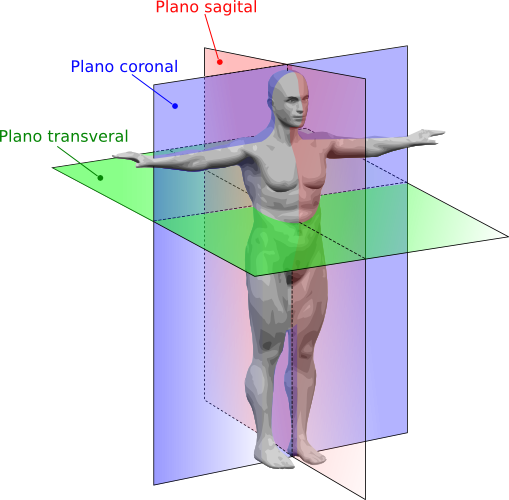

[Fonte da Imagem](https://pt.wikipedia.org/wiki/Plano_anat%C3%B3mico)

</center>

<p>&nbsp;</p>

No exame no qual os dados do arquivo foram obtidos, usou-se o plano transversal (em verde). Foram feitas diversas leituras, em alturas diferentes, com variação milimétrica entre si. Cada leitura dessa é um *slice* e os dados magnéticos detectados foram armazenados. No arquivo `.npy`, essas informações já se encontram normalizadas e ajustadas para valores inteiros no intervalo padrão de visualização de imagens ($[0,255]$).

<p>&nbsp;</p>

Cada fatia pode ser visualizada como uma imagem monocromática e, do empilhamento de todas, é possível tanto se criar visualizações em três dimensões, quanto se fazer projeções nos outros dois eixos (coronal e sagital) para se visualizar ângulos diferentes.

<p>&nbsp;</p>

Nestes dois outros planos também é possível se variar o ponto de visualização no eixos da "largura" e da "profundidade" e fazer visualizações de fatias nos referidos planos.

<p>&nbsp;</p>

Execute a célula a seguir para carregar os dados e exibir o formato da estrutura de dados.

In [ ]:
dados = np.load('dados_medicos/hipercubo_c02.npy')
print(dados.shape)

Para entendermos melhor como avaliar este formato, vamos, primeiro, fazer uma interpretação geométrica. Use a figura ilustrativa do corpo humano, acima, para acompanhar.

<p>&nbsp;</p>

Um pixel na posição $(x,y,z)$ representa a intensidade do sinal na largura $x$, altura $y$ e profundidade $z$ da região escaneada pelo aparelho de ressonância durante o exame. Assim:

<p>&nbsp;</p>

- Quando se estabelece um valor arbitrário para $x$, a matriz de dados resultante corresponde aos dados do plano sagital (vermelho) da "largura" $x$

- Quando se estabelece um valor arbitrário para $y$, a matriz de dados resultante corresponde aos dados do plano transversal (verde) na leitura da "altura" $y$.

- Quando se estabelece um valor arbitrário para $z$, a matriz de dados resultante corresponde aos dados do plano coronal (azul) da "profundidade" $z$

<p>&nbsp;</p>

No cruzamento dos 3 planos, temos o pixel da posição $(x,y,z)$. O dado ali contido é uma leitura de intensidade da ressonância medida ali.

<p>&nbsp;</p>

No entanto, devido à maneira que os dados foram obtidos e tratados para serem dispostos no repositório a ordenação dos eixos $(i,j,k)$ está diferente da exemplificada na figura ilustrativa.

<p>&nbsp;</p>

**Obs.:** Não vamos usar a noção de <u>eixos</u> $x$, $y$ e $z$, para evitar confusões com a interpretação geométrica. Assim, teremos as <u>dimensões</u> $i$, $j$ e $k$.

<p>&nbsp;</p>

Na **aquisição**, foram feitas $685$ leituras de sinais de planos transversais, em uma matriz de $247$ linhas por $322$ colunas. Assim:

- A primeira dimensão ($i$) representa a "altura" e determina o plano transversal, composto por profundidade, nas suas linhas e largura, nas suas colunas. Este é o plano no qual as imagens foram adquiridas.

- A segunda dimensão ($j$) representa a "profundidade" e determina o plano coronal, composto por altura, nas suas linhas e largura, nas suas colunas.

- A terceira dimensão ($k$) representa a "largura" e determina o plano sagital, composto por profundidade, nas suas linhas e altura, nas suas colunas.

<p>&nbsp;</p>

Execute a célula a seguir para ver uma visualização de projeções em cada plano, obtidas da matriz `dados`, carregada do aquivo `.npy`, usando as coordenadas do centro do array.

In [ ]:
display(Image.open('exemplos/planos_npy.png'))

Variando-se os valores de $i$, $j$ e $k$, tem-se os deslocamentos dos planos, possibiltando novas projeções.

<p>&nbsp;</p>

Execute a célula a seguir para visualizar um exemplo variando os valores para cada dimensão.

In [ ]:
display(Image.open('exemplos/planos_variados.png'))

### **Tarefa 1**

Replique, na célula a seguir, os resultados das duas imagens de exemplo anteriores. Elas estão na pasta `exemplos` e se chamam `planos_npy.png` e `planos_variados.png`, respectivamente.

<p>&nbsp;</p>

Use a função pronta `mostrar_imagens` para gerar as visualizações.

In [ ]:
#################### COMPLETE COM SEU CÓDIGO #############

### **Tarefa 2**

Uma tarefa extremamente comum no processamento de imagens médicas é segmentar regiões que representam certos órgãos ou tecidos. Muitas vezes, trabalha-se utilizando limiares de binarização para se localizar os pixels de interesse.

<p>&nbsp;</p>

Neste exercício, vamos tentar segmentar com foco nos ossos do paciente, por meio do usuo de limiarização. O resultado final ficará com ruídos de outros tecidos, por conta de também se apresentarem com tons claros, mas não faremos a limpeza deste tipo de ruído.

<p>&nbsp;</p>

Para limiarizar, portanto, precisamos fazer uma análise dos tons de cinza presentes em algum *slice* dos dados. Uma fatia interessante para isso é extrair o plano sagital referente ao centro da imagem. Execute a célula a seguir para visualizar o plano referenciado.

In [ ]:
fatia = dados[:,:,dados.shape[2]//2]
display(toPil(fatia))

Note que o paciente está virado para o lado esquerdo da tela, com a cabeça para cima. Podemos notar os ossos em tons mais claros, próximos ao branco. Nesta imagem, é possível se identificar facilmente a coluna cervical, o esterno, no peito do paciente e um osso do pélvis. Vamos focar nesse fato: os ossos estão na região mais clara, mais ao topo da escala de valores.

<p>&nbsp;</p>

A estratégia de segmentação que vamos seguir consiste em:

1. Separar os pixels da faixa mais alta de valores, descartando todo o resto. Podemos controlar isso estabelecendo um valor percentual de pixels mais intensos que queremos deixar. Por exemplo, $p = 0.21$, significa que queremos deixar os $21\%$ pixels de valor mais alto, ou, em outras palavras, remover os $79\%$ pixels de valor mais baixo (mais escuro)

2. Após esse processo, a imagem resultante ficará majoritariamente escura, com muitos pixels pretos absolutos (valor zero). Tanto para remover os pixels que passaram no filtro, mas que estão próximos ao limiar de corte, quanto para enfatizar o contraste, vamos normalizar o resultado:

  - Se normalizarmos usando mínimo e máximo, o resultado não mudará, pois o mínimo da imagem já seria zero (a maioria dos pixels, inclusive, conforme já mencionado)

  - Vamos normalizar, então, apenas dentro da faixa de valores dos pixels não zerados. A melhor maneira de se fazer isso é:

    1. Descobrir qual o mínimo valor não zero

    1. Atribuir esse valor mínimo a todos pixels com valor zero. Agora, teremos uma imagem de contraste reduzido, apenas com valores entre $\text{min}(p > 0)$ e  $\text{max}(p > 0)$

    1. Efetuar o alargamento de contraste da imagem (normalizar ente 0 e 255)

<p>&nbsp;</p>

Execute a célula a seguir para ver exemplos do resultado da aplicação de cada passo desses na mesma fatia de dados do exemplo anterior.


In [ ]:
display(Image.open('exemplos/passos_segmentacao.png'))

Note a presenção de ruídos na imagem final. Neste exercício, não nos importaremos com eles.

<p>&nbsp;</p>

Na célula a seguir, implemente o corpo da função `segmenta`, que recebe como entrada:

- `arr_orig`: array de dados original, completo. Não somente uma fatia.

- `perc`: percentual $\text{perc}\%$ pixels mais claros da imagem que se deseja manter na segmentação. Valor *default*: `None`.

- `th`: limiar (*threshold*) de corte. Deve corresponder a um valor de intensidade (tom) do domínio RGB ($[0,255]$). Valor *default*: `None`.

Saída:

- `arr`: array de dados segmentado. Completo, com todas fatias. **Atenção**: Tome cuidado para não alterar o array original de entrada.

- `perc`: o valor percentual de dados mantidos. Se `th` foi informado na entrada, `perc` é calculado em função dele.

- `th`: o valor do limiar para corte. Se `perc` foi informado na entrada, `th` é calculado em função dele.

<p>&nbsp;</p>

**Observações sobre implementação:**

- Há um trecho de código pronto, onde se garante que o usuário informe apenas um dos parâmetros `perc` e `th`. Verifique os comentários para ver como isso é feito.

- O corte de pixels será feito **sempre** por meio do limiar `th`. Ou seja, se ele não foi infomado na entrada, deve ser calculado a partir de `perc`. Existem diferentes caminhos para se fazer este cálculo. Dois exemplos seriam o uso de histogramas CDF ou o uso de quantis (`np.quantile`, na `numpy`, caso prefira). Esteja à vontade para escolher sua solução.

- Se for informado apenas `th`, calcule o percentual de pixels cujo valor é superior a `th`, para retornar na função.

- Por fim, o corte deve seguir o seguinte critério:

  - Se valor de $p > \text{th}$, então $p' \leftarrow p$
  - Caso contrário, $p' \leftarrow 0$

- Note que trata-se de uma **limiarização**, ou seja, estamos trabalhando com limiares, mas **não** estamos binarizando a imagem, pois os valores que passam no filtro são mantidos, ao invés de definidos para $1$ (ou $255$).

In [ ]:
def segmenta(arr_orig, perc=None, th=None):
    # Operador ^: ou exclusivo
    # Garante que somente um dos parâmetros opcionais foi informado
    # Se nenhum deles for informado, lança exceção
    # Se os dois forem informados, também lança exceção
    if not ((perc is None) ^ (th is None)):
    raise ValueError('Apenas um dos parâmetros th ou perc deve ser informados. Não se pode deixar os dois vazios e nem informar ambos.')
    
    #################### COMPLETE COM SEU CÓDIGO #############
    
    return arr, perc, th

- A ideia da função é segmentar o hipercubo de dados como um todo, pois todas camadas precisam deste processo.

- Apenas em tempo de visualização que extrairemos fatias do hipercubo segmentado

- Execute a célula a seguir para ver exemplos da aplicação da segmentação em várias fatias em planos diferentes. Note a presença de fatias todas pretas, indicando que todo conteúdo ali foi eliminado nos fitros.

In [ ]:
display(Image.open('exemplos/segm_planos_variados.png'))

Execute a célula a seguir para testar sua solução:

In [ ]:
npassos = 7

segm, _, th = segmenta(dados, perc=0.1)

print(f'Limiar usado: {th:.0f}')

imgs = []
legs = []
for j in range(0, segm.shape[1], segm.shape[1]//npassos):
  imgs.append(toPil(segm[:,j,:]))
  legs.append(f'Plano Coronal, j={j}')

mostrar_imagens(imgs, legs)

### **Tarefa 3**

É possível se fazer uma espécie de "Projeção 3D" em um eixo para uma tentativa de ter uma visualização melhor da segmentação em várias camadas ao mesmo tempo.

<p>&nbsp;</p>

Para isso, percorra um eixo de sua escolha e inicialize a matriz de projeção com a primeira fatia daquele plano. Vá percorrendo cada fatia do hipercubo, trazendo para a matriz da projeção sempre o valor máximo de pixel entre o dado presente atualmente na projeção e o dado da mesma posição na fatia sendo visitada no loop.

<p>&nbsp;</p>

O resultado final fica como o da figura a seguir (execute a célula).

In [ ]:
display(Image.open('exemplos/projeções.png'))

Note que **não** se trata de uma visualização "3D" de fato, mas de um **artifício** para que se possa tentar analisar o resultado de várias camadas simultaneamente. Em uma visualização realista do plano coronal, por exemplo, a coluna vertebral não estaria visível, pois há uma série de tecidos à sua frente. Mas, como o valor dos ossos densos normalmente estão no máximo de cada posição correspondente nas camadas, eles acabam por serem visualizados na projeção.

<p>&nbsp;</p>

Replique, na célula a seguir, a solução descrita e ilustrada acima.

In [ ]:
#################### COMPLETE COM SEU CÓDIGO #############

---

# **No espaço, novamente**

Em questões anteriores, visitamos imagens produzidas não por captação da luz, mas pelo sensoriamento de outros fenômenos, como radar (radiofrequência) e ressonância magnética (alterações em campos eletromagnéticos). Vamos finalizar este trabalho com imagens *multiespectrais*.

<p>&nbsp;</p>

Imagens multiespectrais são aquelas adquiridas simultaneamente por vários fenômenos diferentes. Normalmente, por diferentes faixas de valores do espectro de ondas eletromagnéticas.

<p>&nbsp;</p>

Mais uma vez, trabalharemos com imagens reais, obtidas por satélites que monitoram diversas regiões do globo terrestre. Nos arquivos que estão presentes na pasta `multi_espectral`, se encontram uma série de arquivos `.npy`, contendo dados de leituras feitas por satélite em 7 bandas diferentes, entre luz visível (RGB) e espectros de infra-vermelho.

<p>&nbsp;</p>

O princípio de tais imagens é que, diferentes tipos de superfície e diferentes tipos de composição química presentes em uma região refletem não só a luz, mas também radar e infra-vermelho, de maneiras distintas. Assim, uma área coberta por vegetação saudável, florestada, vai gerar leituras diferentes de uma área urbana, que vai gerar leituras diferentes daquelas de massas d'água e assim por diante.

<p>&nbsp;</p>

Os arquivos de nome `S_dd.npy`, onde `dd` é um contador numérico, correspondem às leituras de satélite sobre as mesmas 5 regiões da França que abordamos no exercício que falava sobre radares. Note que são as mesmas regiões, mas foram obtidas por satélites diferentes, porém rigorosamente na mesma posição quando cada um deles obteve seus dados.

<p>&nbsp;</p>

Diferentemente do caso dos radares, não temos, aqui uma série temporal de leituras ruidosas, mas sim dados "limpos", com uma leitura por canal. No entanto, são 7 canais:

  - Canal 0: luz visível, na faixa do vermelho (R)
  - Canal 1: luz visível, na faixa do verde (G)
  - Canal 2: luz visível, na faixa do azul (B)
  - Canal 3: leituras NIR (*Near Infrared*), já no espectro do infra-vermelho
  - Canal 4: leituras SWIR-1 (*Short-wave infrared*), infra-vermelho de ondas curtas, em uma determinada faixa de frequência
  - Canal 5: leituras SWIR-2 (*Short-wave infrared*), infra-vermelho de ondas curtas, em uma faixa de frequência diferente do canal anterior
  - Canal 6: leituras *Narrow NIR*, similar ao NIR, porém em uma faixa mais restrita

<p>&nbsp;</p>

Combinando as leituras destes canais de maneiras distintas podemos analisar uma série de fatores distintos sobre a área monitorada. Comecemos com um exemplo simples. Execute a célula seguir para carregarmos os dados do arquivo `S_00.npy`.

In [ ]:
dados = np.load('multi_espectral/S_00.npy')
print(dados.shape)

Temos, portanto, uma imagem de $128 \times 128$ pixels, composta por 7 canais. Podemos fazer a visualização mais comum de todas, a RGB, usando os 3 primeiros canais, conforme descrito acima.

<p>&nbsp;</p>

Um aspecto importante é que muitas vezes os dados adquiridos estão em unidades ou ordem de grandeza diferentes da que costumamos trabalhar no RGB padrão. Vejamos se é o caso, aqui, antes de prosseguirmos com a visualização. Execute a célula a seguir.

In [ ]:
print(f'Tipo de dado contido no array: {dados.dtype}')

De saída, vemos que temos um primeiro empecilho. Os dados estão em ponto flutante de 64-bits. Muito mais do que necessitamos para a visualização RGB. Antes de fazermos os ajustes, no entanto, vamos dar uma olhada no domínio dos dados, por canal. Execute a célula a seguir.

In [ ]:
for c in range(dados.shape[2]):
    print(f'Intervalo de valores do canal {c}: {dados[:,:,c].min()} a {dados[:,:,c].max()}')

Os dados até parecem ser, na prática, valores inteiros, mas sua abrangência está muito maior do que os $256$ valores que estamos habituados. Isso pode acontecer devido a uma série de fatores, entre eles o próprio pré-processamento feito na aquisição das leituras.

<p>&nbsp;</p>

Portanto, o primeiro passo, antes de qualquer coisa, é normalizar os valores e ajustar o tipo de dados. Execute a célula a seguir:

In [ ]:
# A normalização deve ser feita POR CANAL:
# Abaixo, como seria o código iterativo:

# for c in range(dados.shape[2]):
#   dados[:,:,c] = (dados[:,:,c] - dados[:,:,c].min()) / (dados[:,:,c].max() - dados[:,:,c].min()) * 255

# Versão numpy
minimos = dados.min(axis=(0,1))
print(f'Formato do array de mínimos por canal: {minimos.shape}')
maximos = dados.max(axis=(0,1))
print(f'Formato do array de máximos por canal: {maximos.shape}')
dados = (dados - minimos) / (maximos - minimos) * 255
print(f'Formato do array de normalizado: {minimos.shape}')
print()

# Conferindo:
for c in range(dados.shape[2]):
  print(f'Intervalo de valores do canal {c}: {dados[:,:,c].min()} a {dados[:,:,c].max()}')
print()

# Ajuste de tipos
dados = dados.round().astype(np.uint8)
print(f'Tipo de dado contido no array: {dados.dtype}')

Ajustes feitos, podemos, enfim, fazer a primeira visualização, dos canais RGB.

<p>&nbsp;</p>

Execute a célula a seguir

In [ ]:
rgb = dados[:,:,:3]
display(toPil(rgb))

Nem toda tarefa é fácil de se fazer usando RGB. Por exemplo, você conseguiria distinguir, facilmente, corpos d'água na foto acima?

<p>&nbsp;</p>

Em massas de água doce, a tarefa pode ser complicada, pois fatores como solo, profundidade, sedimentos, ou até mesmo reflexo da vegetação ao redor, dentre outros, podem fazer com que os corpos d'água adquiram tonalidades similares às da vegetação.

<p>&nbsp;</p>

Mas, em termos de temperatura, que está relacionada com o infra-vermelho, a diferença pode ser muito mais visível. Por exemplo, a vegetação saudável e densa tende a refletir bem as ondas NIR, enquanto corpos d'água não. Vejamos uma visualização apenas do canal NIR. Execute a célula a seguir.

In [ ]:
nir = dados[:,:,3]
display(toPil(nir))

Note como existem duas regiões que se destacam na imagem, por serem mais escuras. Na visualização NIR, as áreas mais intensas estão associadas a regiões de vegetação mais saudável e densa, enquanto a água a tons escuros.

<p>&nbsp;</p>

Em uma tarefa de segmentação de volumes de água, bastaria limiarizar ou binarizar a imagem monocromática e já teríamos resolvido o problema.

<p>&nbsp;</p>

Mas, é muito comum a tarefa de se desejar segmentar diferentes regiões de interesse, com características distintas. Para isso, usa-se combinações dos canais multi espectrais ou até mesmo índices calculados a partir dos mesmos. Cada uma destas combinações é projetada para otimizar um tipo de análise de interesse. Por exemplo, para análise de áreas florestadas, é comum se fazer uma visualização com os canais [NIR, R, G], mapeados para os canais [R, G, B].

<p>&nbsp;</p>

Veja um exemplo a seguir, executando a célula.

In [ ]:
# Original: NIR = canal 3, R = canal 0, G = canal 1
# Visualização de vegetação: NIR = canal 0, R = canal 1, G = canal 2
vegetacao = dados[:,:,[3,0,1]]
display(toPil(vegetacao))

Essa combinação de visualização permite destacar com facilidade a vegetação saudável (vermelho forte e vivo), água (tons escuros) e solo exposto / área construída (ciano e azul).

<p>&nbsp;</p>

Das inúmeras possibilidades, podemos destacar aqui as seguintes:

| Combinação de Canais              | Alvo da Análise        | Interpretação                                                                                                                                                    |
|----------------------------------|-------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| [R, G, B]                        | Luz visível            | Inspeção visual                                                                                                                                                  |
| [NIR, R, G]                      | Cobertura vegetal      | Vegetação saudável: vermelho vivo; solo exposto/área urbana: azul e ciano; água: tons escuros                                                                   |
| [SWIR-1, NIR, R]                 | Área urbana            | Área urbana/solo exposto: roxo, azul e ciano; vegetação: verde; água: tons escuros                                                                              |
| [G, Narrow-NIR, SWIR-1]          | Corpos d'água          | Similar ao anterior, com água em tons escuros, vegetação em verde e áreas urbanas e solo exposto em ciano, amarelo ou marrom                                   |
| [SWIR-2, NIR, R]                 | Queimadas e solo exposto | Solo exposto e queimadas: vermelho e marrom; vegetação saudável: verde; áreas urbanas: ciano                                                                      |
| [SWIR-2, SWIR-1, Narrow-NIR]     | Aspectos geológicos    | Áreas urbanas em tons quentes como amarelo e laranja; vegetação em tons frios e azulados; facilita distinguir diversos tipos de minerais                         |


<p>&nbsp;</p>

Aplique as combinações da tabela às regiões da França (arquivos de `S_00.npy` a `S_04.npy`) e reproduza a seguinte visualização (execute a célula a seguir):

In [ ]:
display(Image.open('exemplos/multi_espectral_fr.png'))

Note como fica muito mais fácil detectar massas de água em meio a vegetações e também note o comportamento distinto entre água doce (ex.: região 1 e na última) e salgada (região 4) que, diga-se de passagem, também possui pequenos locais de água doce.

<p>&nbsp;</p>

De posse destas informações e do radar, é possível uma série de análises. Estes exemplos da França foram obtidos de um *dataset* voltado para o treinamento de redes neurais, então as imagens, originalmente, têm rótulos anotados para cada tipo de área e existem mais 5 canais que não utilizamos aqui. Porém, são imagens pequenas ($128 \times 128$ pixels).

<p>&nbsp;</p>

Vamos testar, agora, em dados maiores e do Brasil. Temos dados de 5 municípios: Araguari (pop. aprox.: 188 mil habs.) e Araponga (pop.: 8 mil habs.), ambas em Minas Gerais, Luis Eduardo Magalhães (pop.: 90 mil habs.), na Bahia, Rio Verde (pop. 241 mil habs.), em Goiás e Sorriso (pop.: 93 mil habs.), no Mato Grosso.

<p>&nbsp;</p>

Embora obtidas com o mesmo satélite (*Sentinel-2*) dos casos franceses, as imagens são consideravelmente maiores e trabalharemos com versões reduzidas aqui. A organização das matrizes dos arquivos é a mesma do caso anterior, e as mesmas visualizações podem ser geradas, se você desejar.

<p>&nbsp;</p>

No entanto, nosso foco, aqui, será outro: a segmentação de imagens. Na análise deste tipo de dados é comum o cálculo de índices a partir das bandas disponíveis. Vamos brincar com dois deles: NDVI e NDBI. Mas existem muitos mais.

<p>&nbsp;</p>

O índice NDVI (*Normalized Difference Vegetation Index*) busca explorar a maneira como a vegetação reage (reflete) o sinal da faixa NIR, do espectro e também como reage à luz vermelha. As plantas verdes tendem a absorver fortemente a luz vermelha e refletir as ondas NIR. Desta forma, faz-se o seguinte cálculo:

$$
\text{NDVI} = \frac{\text{NIR} - \text{R}}{\text{NIR} + \text{R}}
$$


Que mede a diferença de reflexão entre as duas bandas, normalizada pelo total de sinal das mesmas. Assim, temos que $\text{NDVI} \in [-1,1]$ e valores positivos indicam vegetação mais saudável, enquanto valores negativos indicam menos vegetação.

<p>&nbsp;</p>

Um outro índice é o NDBI (*Normalized Difference Buit-up Index*), que busca medir o grau de reflexão de áreas urbanizadas ou de solo exposto. Estas áreas tendem a refletir mais o infravermelho de ondas curtas do que o infravermelho próximo. Asim, temos:

$$
\text{NDBI} = \frac{\text{SWIR-1} - \text{NIR}}{\text{SWIR-1} + \text{NIR}}
$$

De maneira análoga ao caso anterior, $\text{NDBI} \in [-1, 1]$ e valores maiores indicam mais área exposta/construída.

<p>&nbsp;</p>

Neste exercício vamos usar estes índices para segmentar as imagens de satélite. No caso extrairemos áreas florestadas, de vegetação densa e áreas com alto grau de exposição do solo, o que incluirá áreas urbanas. Um algoritmo generalizado, para isso, seria:

<p>&nbsp;</p>

1. Carregue os dados multi espectrais e normalize seus valores

1. Gere uma visualização RGB, usando os canais apropriados (Imagem A, abaixo)

1. Calcule o índice desejado (NDVI ou NDBI), a partir dos canais envolvidos em cada caso

1. Use a matriz calculada com os valores do índice desejado para gerar uma imagem monocromática (Imagem B, abaixo)

1. Utilize o algoritmo de Otsu para binarizar a imagem monocromática (Imagem C, abaixo)

1. Gere a imagem segmentada, pelo produto da imagem RGB pela binária. Ou seja:

  - Onde os pixels são pretos na imagem binária, isto é, possuem o valor zero, resultarão em pixels preto na imagem segmentada.
  
  - Onde os pixels forem brancos na imagem binária, isto é, possuem o valor um, resultarão em pixels com os mesmos valores originais na imagem RGB.

  - Em outras palavra, a imagem binária será uma máscara para seleção de pixels na imagem RGB

  Execute a célula abaixo para visualizar os resultados do processo descrito, tanto para o caso NDVI, quanto para o caso NDBI. Ambos estão ilustrados com os dados de Araguari (MG).

In [ ]:
display(Image.open('exemplos/araguari_ndvi_otsu.png'))
display(Image.open('exemplos/araguari_ndbi_otsu.png'))

Pede-se:

1. Implemente o código da função `lim_otsu`, na célula a seguir, para que seja possível a realização dos passos descritos. A função deve retornar o **valor de limiar** calculado, e não a imagem segmentada.

1. Utilize a função que você implementou para replicar os resultados para Araguari (MG), para fins de conferência da implementação. Mas também gere as segmentações para cada uma das outras cidades.

  - Ou seja, **crie** uma função segmentadora por índice, onde se informa a matriz de dados, o nome do índice que se deseja utilizar e ela retorna as quatro matrizes descritas, para que sejam transformadas em imagens e visualizadas posteriormente.

  - Acrescente quantas células de código desejar para resolver este exercício.

In [ ]:
def lim_otsu(img):
    if isinstance(img, Image.Image):
        arr = extrai_array(img)
    elif isinstance(img, np.ndarray):
        arr = img
    else:
        raise TypeError('Tipo de dado não suportado.')
    
    #################### COMPLETE COM SEU CÓDIGO #############
    
    return th

In [ ]:
# Implemente aqui sua solução para as visualizações

Para encerrar, note, nas imagens de exemplo, que apesar de segmentadas, tanto a de vegetação, quanto a de solo exposto ainda carregam consigo bastante ruído vindo do outro caso. Em outras palavras, tem ruído de solo exposto na segmentação de vegetação e vice-versa.

<p>&nbsp;</p>

Adapte a solução acima para que, ao invés de binarizar via algoritmo de Otsu, binarize por percentil de pixels. Ou seja, ao invés de usar a solução de Otsu para dividir entre pixels pretos e brancos, use um valor percentual. Assim, o limiar de binarização será aquele valor a partir do qual $\text{perc}\%$ dos pixels mais intensos da imagem se tornarão brancos. Já exploramos essa ideia, de maneira similar, em um exercício anterior. As dicas, inclusive, são as mesmas: usar CDF ou `np.quantile`.

<p>&nbsp;</p>

Como antes, na célula a seguir tem-se a ilustração do uso de tal técnica, mantendo-se apenas um percentual de pixels mais intensos, para cada índice, para o município de Araguari (MG).

<p>&nbsp;</p>

Também com antes, gere os resultados para as 5 cidades brasileiras e acrescente quantas células de código desejar.

In [ ]:
display(Image.open('exemplos/araguari_ndvi_perc.png'))
display(Image.open('exemplos/araguari_ndbi_perc.png'))

In [ ]:
# Implemente aqui sua solução para as visualizações

**Obs.:** Caso deseje, na subpasta `composicoes`, dentro da pasta `exemplos`, encontram-se imagens com os resultados das composições da tabela que usamos para as imagens da França, aplicadas aos 5 municípios brasileiros.

---

# **E terminamos no espaço... De cores!**

Neste exercício, você irá explorar técnicas de **realce de contraste e manipulação de luminância** utilizando o espaço de cor HSL/HLS. A ideia central é comparar o efeito de manipular apenas o canal de luminância em HSL, construindo versões intermediárias da imagem e analisando visualmente os resultados. Para isto, vamos tentar gerar uma espécie de balanceamento de regiões claras e escuras em uma imgem.

<p>&nbsp;</p>

Neste exercício não se deve usar as conversões prontas de bibliotecas como OpenCV, `colorsys` ou similares para conversões `RGB ↔ HSL`. As conversões devem ser implementadas por você, a partir das fórmulas fornecidas no material didático, utilizando apenas PIL + NumPy.

<p>&nbsp;</p>

Nas duas células a seguir, implemente as conversões de cores `rgb2hsl` e `hsl2rgb`, que recebem o array da imagem no formato desejado e entrega o array da imagem no novo espaço de cores.

In [ ]:
def rg2hsl(arr):
    ############################ COMPLETE COM SEU CÓDIGO

In [ ]:
def hsl2rgb(arr):
    ############################ COMPLETE COM SEU CÓDIGO

#### Para este exercício, utilize a imagem `imagens/igrejinha.png` e siga os seguintes passos:

1. Carregue e converta a imagem para tons de cinza (pode usar a conversão implementada na biblioteca PIL)
2. Converta a imagem original (colorida) para o espaço HSL, usando sua função
3. Inverta apenas o canal de luminância $L$, isto é, para cada pixel: $L' = 1 - L$
4. Converta o resultado novamente para o espaço RGB. Chamaremos esta imagem de "negativo de L", para referência
5. Calcule o histograma da imagem em tons de cinza com 256 níveis (0 a 255), que você gerou no primeiro passo. Para o histograma CDF, está liberado uso de funções de bibliotecas
6. Encontre um limiar $t$ tal que a CDF seja o mais próxima possível de 0,5 (metade dos pixels). Este valor $t$ será usado para separar regiões claras e regiões escuras da imagem.
7. A partir da imagem original e da imagem “negativo de L”:
    - Crie uma cópia da imagem original para o caso “balanceado para claro” (chame de `balClaro`). Em `balClaro`, substitua os pixels nas regiões mais escuras (por exemplo, onde o valor em cinza é $< t$) pelos pixels correspondentes da imagem “negativo de L”.
    - Crie outra cópia, “balanceada para escuro” (`balEsc`). Em `balEsc`, substitua os pixels nas regiões mais claras (por exemplo, onde o valor em cinza é $> t$) pelos pixels correspondentes da imagem “negativo de L`.
    - Intuição:
        - `balClaro`: tenta realçar mais as regiões originalmente escuras.
        - `balEsc`: tenta realçar mais as regiões originalmente claras.
8. Calcule a média, pixel a pixel, entre `balClaro` e `balEsc`, gerando uma nova imagem chamada `media`.
9. Para cada uma das 3 imagens coloridas `balClaro`, `balEsc` e `media`, aplique o alargamento de constraste, conforme visto em aulas. Para cada imagem, gere uma versão com alargamento, **sem** substituir as imagens originais.
10. Usando a função `mostrar_imagens`, gere uma visualização comparativa entre as seguintes imagens:
    1. Original
    2. Negativo tradicional do RGB
    3. Negativo de L
    4. Balanceada para claro
    5. Balanceada para escuro
    6. Média
    7. Alargamento de balanceada para claro
    8. Alargamento de balanceada para escuro
    9. Alargamento da média

Produza legendas adequadas para cada imagem. Na função mostrar imagens, pode-se definir quantas imagens por linha serão exibidas. Neste caso, 5 ou 6 por linha produz um bom resultado.

In [ ]:
############################ COMPLETE COM SEU CÓDIGO

---

# **3. Envio**

- **Limpe as saídas em tela** antes de enviar. Isso diminui significativamente o tamanho do arquivo final e não gera problemas de recusa de submissão no Moodle. Para isso:
  - Vá no menu *Editar*
  - Escolha a opção *Limpar todas as saídas*
- **Salve** o notebook (`Ctrl + S`)
- Compacte, **ambos**, notebook e arquivos `roles.txt`, em formato `.zip` com o nome `p06_matrícula.zip`, substituindo "matrícula" pela matrícula da UFV do estudante responsável pelo envio.
- **Não** envie as imagens.
- Envie o pacote `.zip` como resposta da atividade, via **Moodle** (só será aceito nesse formato).